In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import pandas_datareader as pdr
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
from finta import TA
from sklearn.model_selection import TimeSeriesSplit,cross_val_score,cross_validate
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#import yahoofinancials
import matplotlib.pyplot as plt
import numpy as np
#from hyperopt import hp
from numpy import mean
from numpy import std
from numpy import dstack
#from pandas import read_csv
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Nadam
from tensorflow.keras.layers import GaussianNoise,Activation,Dense,Conv1D,MaxPooling1D,Input,Dropout,BatchNormalization,Flatten,LeakyReLU,Dropout

import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [2]:
#!pip install yfinance finta
#import keras 
import tensorflow as tf
tf.__version__

'2.1.0'

In [3]:
data=yf.Ticker('MXN=X')
data=data.history(period="max")
data=data.loc["2000-01-20":"2020-12-31"][["Open","High","Low",'Close']]
data.tail()

,Open,High,Low,Close
Date,,,,
2020-08-19,22.1345,22.1842,22.0093,22.1313
2020-08-20,22.1772,22.3208,22.1151,22.1748
2020-08-21,22.0684,22.1695,21.9863,22.0883
2020-08-24,21.9590,22.0023,21.8671,21.9597
2020-08-25,22.0024,22.0121,21.8707,21.9765


In [4]:
sp=yf.Ticker('SPY')
sp=sp.history(period="max")
sp=sp.loc["2000-01-20":"2020-12-31"][["Open","High","Low",'Close']]
sp.tail()

,Open,High,Low,Close
Date,,,,
2020-08-19,339.05,339.61,336.62,337.23
2020-08-20,335.36,338.80,335.22,338.28
2020-08-21,337.92,339.72,337.55,339.48
2020-08-24,342.12,343.00,339.45,342.92
2020-08-25,343.53,343.70,342.27,342.84


In [5]:
data=data.join(sp,how="left",rsuffix="sp")

In [6]:
data["sp_percent_change"] = data["Closesp"].pct_change(periods=1).astype(float)
#data = data.merge(SP["sp_percent_change"], left_index=True, right_index=True,how="left")
data["percent_change"] = data["Close"].pct_change(periods=1).astype(float)
# Daily percent change as compared to the S&P 500
data["relative_change"] = data["percent_change"] - data["sp_percent_change"]
data.tail()

,Open,High,Low,Close,Opensp,Highsp,Lowsp,Closesp,sp_percent_change,percent_change,relative_change
Date,,,,,,,,,,,
2020-08-19,22.1345,22.1842,22.0093,22.1313,339.05,339.61,336.62,337.23,-0.004164,-0.000492,0.003671
2020-08-20,22.1772,22.3208,22.1151,22.1748,335.36,338.80,335.22,338.28,0.003114,0.001966,-0.001148
2020-08-21,22.0684,22.1695,21.9863,22.0883,337.92,339.72,337.55,339.48,0.003547,-0.003901,-0.007448
2020-08-24,21.9590,22.0023,21.8671,21.9597,342.12,343.00,339.45,342.92,0.010133,-0.005822,-0.015955
2020-08-25,22.0024,22.0121,21.8707,21.9765,343.53,343.70,342.27,342.84,-0.000233,0.000765,0.000998


In [7]:
data.columns=data.columns.str.lower()

In [8]:
def add_indicators(data):
        # This is a list of all possible indicators we can use
        # indicators = ['ADL', 'ADX', 'AO', 'APZ', 'ATR',
        # 'BASP', 'BASPN', 'BBANDS', 'BBWIDTH', 'CCI', 'CFI', 'CHAIKIN', 'CHANDELIER', 'CMO', 'COPP', 'DEMA', 'DMI',
        # 'DO', 'EBBP', 'EFI', 'EMA', 'EMV', 'ER', 'EVWMA', 'EV_MACD', 'FISH', 'FVE', 'HMA', 'ICHIMOKU', 'IFT_RSI',
        # 'KAMA', 'KC', 'KST', 'MACD', 'MFI', 'MI', 'MOM', 'MSD', 'OBV', 'PERCENT_B', 'PIVOT', 'PIVOT_FIB', 'PPO',
        # 'PZO', 'QSTICK', 'ROC', 'RSI', 'SAR', 'SMA', 'SMM', 'SMMA', 'SQZMI', 'SSMA', 'STC', 'STOCH', 'STOCHD',
        # 'STOCHRSI', 'TEMA', 'TMF', 'TP', 'TR', 'TRIMA', 'TRIX', 'TSI', 'UO', 'VAMA', 'VFI', 'VORTEX', 'VPT', 'VR',
        # 'VWAP', 'VW_MACD', 'VZO', 'WILLIAMS', 'WMA', 'WOBV', 'WTO', 'ZLEMA']

        # Here are all indicators we are using
    indicators = ['SMA', 'SMM', 'SSMA', 'EMA', 'DEMA', 'TEMA', 'TRIMA', 'TRIX', 'ER', 'KAMA', 'ZLEMA',
                      'WMA', 'HMA', 'SMMA', 'MACD', 'PPO', 'MOM', 'ROC', 'RSI',
                      'IFT_RSI']
        # These indicators need more tuning or are broken
    broken_indicators = ['SAR', 'TMF', 'QSTICK']
    for indicator in indicators:
        if indicator not in broken_indicators:
            df = None
                # Using python's eval function to create a method from a string instead of having every method defined
            df = eval('TA.' + indicator + '(data)')
                # Some method return series, so we can check to convert here
            if not isinstance(df, pd.DataFrame):
                df = df.to_frame()
                # Appropriate labels on each column
            df = df.add_prefix(indicator + '_')
                # Join merge dataframes based on the date
            data = data.merge(df, left_index=True, right_index=True)
        # Fix labels
    data.columns = data.columns.str.replace(' ', '_')
    return(data)

In [9]:
data=add_indicators(data)

In [10]:
data.dropna(inplace=True)

In [11]:
data["dir"]=np.sign(data["percent_change"]).shift(-1)
data.dropna(inplace=True)
data["dir"]=data["dir"].apply(lambda x: 1 if x>=0 else 0)
data["dir_ant30"]=data["dir"].rolling(window=30).mean()
data.dropna(inplace=True)

In [12]:
data.tail(7)

,open,high,low,close,opensp,highsp,lowsp,closesp,sp_percent_change,percent_change,...,MACD_SIGNAL,PPO_PPO,PPO_SIGNAL,PPO_HISTO,MOM_MOM,ROC_ROC,RSI_14_period_RSI,IFT_RSI_IFT_RSI,dir,dir_ant30
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-14,22.1538,22.2335,22.0040,22.1539,336.41,337.42,335.62,336.84,0.000030,-0.008370,...,-0.044642,-0.166223,-0.199360,0.033138,0.1585,1.005316,43.365689,2.246718,0,0.466667
2020-08-17,21.9473,22.0671,21.8993,21.9335,337.94,338.34,336.85,337.91,0.003177,-0.009949,...,-0.049068,-0.298845,-0.219257,-0.079588,-0.3271,-0.177495,38.396101,28.448516,1,0.500000
2020-08-18,22.1557,22.2013,22.0078,22.1422,338.34,339.10,336.61,338.64,0.002160,0.009515,...,-0.053761,-0.324859,-0.240378,-0.084482,-0.4835,0.667412,44.841930,122.938024,0,0.466667
2020-08-19,22.1345,22.1842,22.0093,22.1313,339.05,339.61,336.62,337.23,-0.004164,-0.000492,...,-0.058428,-0.345502,-0.261403,-0.084100,-0.4971,-0.580847,44.579571,1366.644451,1,0.500000
2020-08-20,22.1772,22.3208,22.1151,22.1748,335.36,338.80,335.22,338.28,0.003114,0.001966,...,-0.062006,-0.342178,-0.277558,-0.064621,-0.1968,-1.992867,45.938957,15575.388490,0,0.500000
2020-08-21,22.0684,22.1695,21.9863,22.0883,337.92,339.72,337.55,339.48,0.003547,-0.003901,...,-0.065953,-0.366750,-0.295396,-0.071354,-0.3145,-2.386824,43.646336,498.588041,0,0.500000
2020-08-24,21.9590,22.0023,21.8671,21.9597,342.12,343.00,339.45,342.92,0.010133,-0.005822,...,-0.071825,-0.428126,-0.321942,-0.106184,-0.4449,-1.841174,40.416921,57.634761,1,0.500000


In [13]:
X = data.drop('dir', axis=1).values
y = data['dir'].values

# Reshaping CNN




In [14]:
window=15
forecast=1
xx=[]
yy=[]
for i in range(len(X)-window+1):
  xx.append(X[i:i+window].reshape(window,X.shape[1]))
  yy.append(y[i+window-1])

xx=np.array(xx)
yy=np.array(yy)  

In [15]:
xx[-1,-1],yy[-1]

(array([ 2.19590000e+01,  2.20023000e+01,  2.18671000e+01,  2.19597000e+01,
         3.42120000e+02,  3.43000000e+02,  3.39450000e+02,  3.42920000e+02,
         1.01331448e-02, -5.82208681e-03, -1.59552316e-02,  2.23934268e+01,
         2.21422000e+01,  2.22073664e+01,  2.21367962e+01,  2.20421592e+01,
         2.20056176e+01,  2.23056707e+01, -4.33273256e-02,  4.21986152e-01,
         2.22129987e+01,  2.21362729e+01,  2.20967778e+01,  2.19748406e+01,
         2.20215710e+01,  2.23760932e+01, -9.53145958e-02, -7.18250087e-02,
        -4.28125610e-01, -3.21942073e-01, -1.06183537e-01, -4.44900000e-01,
        -1.84117363e+00,  4.04169215e+01,  5.76347613e+01,  5.00000000e-01]),
 1)

In [16]:
data.iloc[-5:]

,open,high,low,close,opensp,highsp,lowsp,closesp,sp_percent_change,percent_change,...,MACD_SIGNAL,PPO_PPO,PPO_SIGNAL,PPO_HISTO,MOM_MOM,ROC_ROC,RSI_14_period_RSI,IFT_RSI_IFT_RSI,dir,dir_ant30
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-18,22.1557,22.2013,22.0078,22.1422,338.34,339.10,336.61,338.64,0.002160,0.009515,...,-0.053761,-0.324859,-0.240378,-0.084482,-0.4835,0.667412,44.841930,122.938024,0,0.466667
2020-08-19,22.1345,22.1842,22.0093,22.1313,339.05,339.61,336.62,337.23,-0.004164,-0.000492,...,-0.058428,-0.345502,-0.261403,-0.084100,-0.4971,-0.580847,44.579571,1366.644451,1,0.500000
2020-08-20,22.1772,22.3208,22.1151,22.1748,335.36,338.80,335.22,338.28,0.003114,0.001966,...,-0.062006,-0.342178,-0.277558,-0.064621,-0.1968,-1.992867,45.938957,15575.388490,0,0.500000
2020-08-21,22.0684,22.1695,21.9863,22.0883,337.92,339.72,337.55,339.48,0.003547,-0.003901,...,-0.065953,-0.366750,-0.295396,-0.071354,-0.3145,-2.386824,43.646336,498.588041,0,0.500000
2020-08-24,21.9590,22.0023,21.8671,21.9597,342.12,343.00,339.45,342.92,0.010133,-0.005822,...,-0.071825,-0.428126,-0.321942,-0.106184,-0.4449,-1.841174,40.416921,57.634761,1,0.500000


In [17]:
xx.shape

(4124, 15, 36)

In [18]:
split=int(xx.shape[0]*.8)
xx_train,xx_test,yy_train,yy_test=xx[:split],xx[split:],yy[:split],yy[split:]

# Modelo convencional

In [19]:

inp=Input(shape=(xx_train.shape[1],xx_train.shape[2],))
x=BatchNormalization()(inp)
x=GaussianNoise(.1)(x)
#x=BatchNormalization()(x)
x=Conv1D(128,10,padding="same",activation=LeakyReLU(.1),kernel_regularizer=l2(.1))(x)
x=BatchNormalization()(x)
#x=Conv1D(64,10,activation=LeakyReLU(.1),kernel_regularizer=l2(.1))(x)
#x=BatchNormalization()(x)
#x=Conv1D(32,10,activation=LeakyReLU(.1),kernel_regularizer=l2(.1))(x)
#x=BatchNormalization()(x)
#x=Dropout(.5)(x)
x=MaxPooling1D(10,padding="same")(x)
x=Flatten()(x)
x=BatchNormalization()(x)
x=Dense(200,activation="tanh",kernel_regularizer=l2(.1))(x)
x=BatchNormalization()(x)
x=Dense(2,activation="softmax")(x)
model=Model(inp,x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 36)]          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 36)            144       
_________________________________________________________________
gaussian_noise (GaussianNois (None, 15, 36)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 15, 128)           46208     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 128)           512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0     

In [20]:
#from keras.utils import to_categorical
import tensorflow as tf
tf.__version__

'2.1.0'

In [21]:
#clear_session()
filepath="comun.hdf5"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,es]
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['acc'])
model.fit(xx_train,to_categorical(yy_train),batch_size=450,epochs=1000,validation_data=(xx_test,to_categorical(yy_test)),callbacks=callbacks_list,verbose=0)


Epoch 00001: val_acc improved from -inf to 0.47636, saving model to comun.hdf5

Epoch 00002: val_acc improved from 0.47636 to 0.48000, saving model to comun.hdf5

Epoch 00003: val_acc did not improve from 0.48000

Epoch 00004: val_acc improved from 0.48000 to 0.52727, saving model to comun.hdf5

Epoch 00005: val_acc improved from 0.52727 to 0.53697, saving model to comun.hdf5

Epoch 00006: val_acc did not improve from 0.53697

Epoch 00007: val_acc did not improve from 0.53697

Epoch 00008: val_acc did not improve from 0.53697

Epoch 00009: val_acc did not improve from 0.53697

Epoch 00010: val_acc did not improve from 0.53697

Epoch 00011: val_acc did not improve from 0.53697

Epoch 00012: val_acc did not improve from 0.53697

Epoch 00013: val_acc did not improve from 0.53697

Epoch 00014: val_acc did not improve from 0.53697

Epoch 00015: val_acc did not improve from 0.53697

Epoch 00016: val_acc did not improve from 0.53697

Epoch 00017: val_acc did not improve from 0.53697

Epoch 0

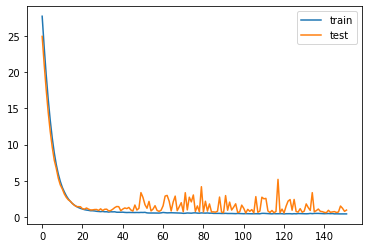

In [22]:
ep=152
plt.plot(range(ep),model.history.history["loss"],label="train")
plt.plot(range(ep),model.history.history["val_loss"],label="test")
plt.legend()

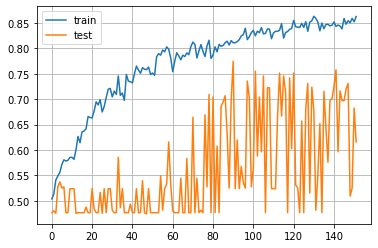

In [23]:
plt.plot(range(ep),model.history.history["acc"],label="train")
plt.plot(range(ep),model.history.history["val_acc"],label="test")
plt.legend()
plt.grid()

In [24]:
from sklearn.metrics import accuracy_score
preds=model.predict(xx_test)
accuracy_score(yy_test,np.argmax(preds,axis=1))

0.6157575757575757

# Descomposición de pesos y neuronas

In [25]:
for j in range(len(model.get_weights())):
    print(model.get_weights()[j].shape)

(36,)
(36,)
(36,)
(36,)
(10, 36, 128)
(128,)
(128,)
(128,)
(128,)
(128,)
(256,)
(256,)
(256,)
(256,)
(256, 200)
(200,)
(200,)
(200,)
(200,)
(200,)
(200, 2)
(2,)


In [26]:
print(model.layers[10].name)
model.layers[10].get_weights()

dense_1


[array([[-0.07058309, -0.15774867],
        [-0.08453475, -0.09707265],
        [ 0.10426814, -0.09460061],
        [-0.1218696 , -0.03692558],
        [ 0.11318286,  0.11234045],
        [ 0.03894456, -0.05200486],
        [ 0.1074628 ,  0.02506709],
        [-0.06859213,  0.09677146],
        [-0.06917678, -0.06938574],
        [ 0.00928293,  0.07167191],
        [ 0.10510252, -0.1598276 ],
        [-0.01376148, -0.01612913],
        [ 0.07079789,  0.01306164],
        [ 0.14528964,  0.0046837 ],
        [-0.11109678, -0.11200728],
        [ 0.09034125,  0.09204318],
        [ 0.00840752,  0.00935943],
        [ 0.13802119, -0.08646858],
        [-0.03592644, -0.03659465],
        [-0.11044974, -0.04863767],
        [-0.13466993, -0.13611005],
        [ 0.05738315,  0.05840416],
        [-0.00099859, -0.13719705],
        [ 0.08580329, -0.00921921],
        [ 0.05107684,  0.16337554],
        [ 0.14182037,  0.05169431],
        [ 0.01316297,  0.01266535],
        [ 0.00790413,  0.009

In [27]:
model.layers[2].output

<tf.Tensor 'gaussian_noise/Identity:0' shape=(None, 15, 36) dtype=float32>

**Input xx[0]**

In [28]:
yy_test[0],xx_test[0]

(0,
 array([[ 1.88233000e+01,  1.89903000e+01,  1.86921000e+01,
          1.88662000e+01,  2.23440000e+02,  2.24420000e+02,
          2.23350000e+02,  2.24040000e+02,  5.79124579e-03,
          2.82250134e-03, -2.96874445e-03,  1.90551561e+01,
          1.87970000e+01,  1.87763276e+01,  1.87596427e+01,
          1.87999599e+01,  1.88709655e+01,  1.88372843e+01,
         -1.83470253e-01,  1.45327827e-01,  1.88449525e+01,
          1.86289752e+01,  1.87653067e+01,  1.88459799e+01,
          1.87844674e+01,  1.94872517e+01, -1.23405344e-01,
         -1.94484576e-01, -6.53729524e-01, -1.02584276e+00,
          3.72113235e-01,  1.12600000e-01,  1.14840232e+00,
          4.89025631e+01,  1.62126898e+02,  5.33333333e-01],
        [ 1.88565000e+01,  1.92868000e+01,  1.88470000e+01,
          1.91632000e+01,  2.24000000e+02,  2.24960000e+02,
          2.23850000e+02,  2.23900000e+02, -6.24888413e-04,
          1.57424389e-02,  1.63673273e-02,  1.90320610e+01,
          1.88117000e+01,  1.881931

## Layer 1 BatchNormalization

$$\mu_{B}=\frac{1}{m} \sum_{i=1}^{m} x_{i} \sigma_{B}^{2}=\frac{1}{m} \sum_{i=1}^{m}\left(x_{i}-\mu_{B}\right)^{2}$$

$$\hat{x}_{i}=\frac{x_{i}-\mu_{B}}{\sqrt{\sigma_{B}^{2}+\epsilon}}$$

$$y_{i}=\gamma * \hat{x}_{i}+\beta$$

incluido un factor pequeño $\epsilon$ para la estabilidad numérica.

**¿Qué son los pesos que obtengo del layer1?**

es un array de la forma $$[\gamma,\beta,\mu_{B},\sigma^2_{B}]$$

In [29]:
print(model.layers[1].name)
from IPython.display import display, Markdown, Latex
display(Latex(f'$\gamma=$ {model.layers[1].get_weights()[0][:5]}...'))
display(Latex(f'$\\beta=$ {model.layers[1].get_weights()[1][:5]}...'))
display(Latex(f'$\mu=$ {model.layers[1].get_weights()[2][:5]}...'))
display(Latex(f'$\sigma^2=$ {model.layers[1].get_weights()[3][:5]}...'))

batch_normalization


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

**¿Cómo obtengo el output de este layer?**
$$y_{i}=\gamma * \hat{x}_{i}+\beta$$

In [30]:
yi=model.layers[1].get_weights()[0]*((xx_test[0]-model.layers[1].get_weights()[2])/np.sqrt(model.layers[1].get_weights()[3]))+model.layers[1].get_weights()[1]


**Comprobamos con la salida parcial del modelo...**

In [31]:
lay1out=[layer.output for layer in model.layers[:2]]
act1mod=Model(model.input,lay1out)

In [32]:
#0.4722627*((1.88470000e+01-1.30844727e+01)/np.sqrt(6.1285200e+00))+-0.36620188

In [33]:
pred1=np.array(act1mod.predict(xx_test[0:1]))[1]
np.abs(yi-pred1)

array([[[1.41228715e-04, 1.58629443e-04, 1.19931819e-04, 1.42504699e-04,
         7.87006676e-07, 5.72862113e-07, 5.39343886e-07, 9.92815328e-07,
         4.92172117e-01, 3.69123431e-01, 1.26305070e-01, 1.76735902e-04,
         1.24526907e-04, 1.25144848e-04, 1.49378518e-04, 1.25352125e-04,
         1.32034544e-04, 1.75198903e-04, 8.36270131e-02, 1.07418399e-02,
         1.57279288e-04, 1.24360865e-04, 1.23471585e-04, 1.53231142e-04,
         1.30621849e-04, 2.15478990e-04, 3.40660113e-02, 6.11150272e-02,
         5.34217843e-04, 1.18432596e-03, 1.22654906e-02, 1.38175831e-03,
         3.06135312e-05, 7.52609697e-07, 9.54705409e-09, 5.66362448e-02],
        [1.41462221e-04, 1.66388826e-04, 1.22942677e-04, 1.49598504e-04,
         7.93859279e-07, 5.86916152e-07, 7.73150027e-07, 1.21820265e-06,
         9.10028592e-02, 2.18774928e+00, 7.48243639e-01, 1.76264850e-04,
         1.25144799e-04, 1.25971940e-04, 1.51511464e-04, 1.27886376e-04,
         1.35969066e-04, 1.74053474e-04, 7.9647572

**¿Por qué las diferencias?**

puede seer la $\epsilon$

## Layer 2 Gaussian_Noise

In [34]:
print(model.layers[2].name)
model.layers[2].get_weights()

gaussian_noise


[]

## Layer 3 Conv1D

In [35]:
print(model.layers[3].name)
model.layers[3].get_weights()

conv1d


[array([[[ 2.26747151e-03, -3.54279066e-03, -5.67819877e-03, ...,
          -2.21014814e-03,  6.22154039e-04,  7.96498207e-04],
         [ 2.12874380e-03, -2.74793198e-03, -1.70454790e-03, ...,
          -2.37773196e-03, -4.41746740e-03,  1.19226717e-03],
         [ 1.82251539e-03, -2.91424827e-03, -2.90959049e-03, ...,
          -1.92967220e-03,  4.22915444e-03,  1.02167192e-03],
         ...,
         [-1.93967100e-03, -4.55022557e-03, -2.44201766e-03, ...,
          -2.47867871e-03,  6.05250429e-03,  2.07856530e-03],
         [ 3.18987819e-04,  1.02343372e-04, -1.18670485e-03, ...,
           3.97747802e-03, -8.04732263e-04, -6.12414151e-05],
         [-7.12941575e-04, -5.32640889e-03,  5.10338368e-03, ...,
          -3.32218874e-03, -6.96267746e-03, -5.26426535e-04]],
 
        [[ 1.45064841e-03, -2.72890693e-03, -3.89302056e-03, ...,
          -2.00823438e-03, -7.52771599e-03,  6.44720683e-04],
         [ 2.39163148e-03, -2.70740758e-03,  6.99239899e-06, ...,
          -1.30287022

**Está es la salida esperada de este layer**

In [36]:
lay1out=[layer.output for layer in model.layers[:4]]
act2mod=Model(model.input,lay1out)
pred2=np.array(act2mod.predict(xx_test[0:1])[-1])
pred2
#np.abs(yi-pred1)

array([[[ 0.49988616, -0.02245388, -0.03638026, ..., -0.02772865,
         -0.0181757 ,  0.45862156],
        [ 0.5916892 , -0.03388537, -0.0572233 , ..., -0.0409736 ,
         -0.02460476,  0.5274807 ],
        [ 0.663618  , -0.04654729, -0.05981088, ..., -0.05215062,
         -0.02391527,  0.58839566],
        ...,
        [ 0.52263415, -0.0505611 , -0.02501746, ..., -0.05115576,
         -0.01355459,  0.49450678],
        [ 0.45072085, -0.04268551, -0.02517319, ..., -0.04435251,
         -0.00441987,  0.436076  ],
        [ 0.3792735 , -0.03508129, -0.03191796, ..., -0.03625619,
         -0.00751726,  0.35973048]]], dtype=float32)

In [37]:
pred2.shape

(1, 15, 128)

In [38]:
yi.shape

(15, 36)

### Entendiendo filtros Conv1D

**Filtros**

Recordar que la configuración de la neurona es Conv1D(128,10,padding="same",activation=LeakyReLU(.1)), lo cual significa que tenemos 128 filtros de tamaño 10 y después se la aplica la función de activación LeakyRelu con $\alpha=0.1$

$$LeakyRelu(x)=f(x)=\left\{\begin{array}{ll}
x & \text { if } x>0 \\
a x & \text { otherwise }
\end{array}\right.$$

¿Cuál es el output esperado?



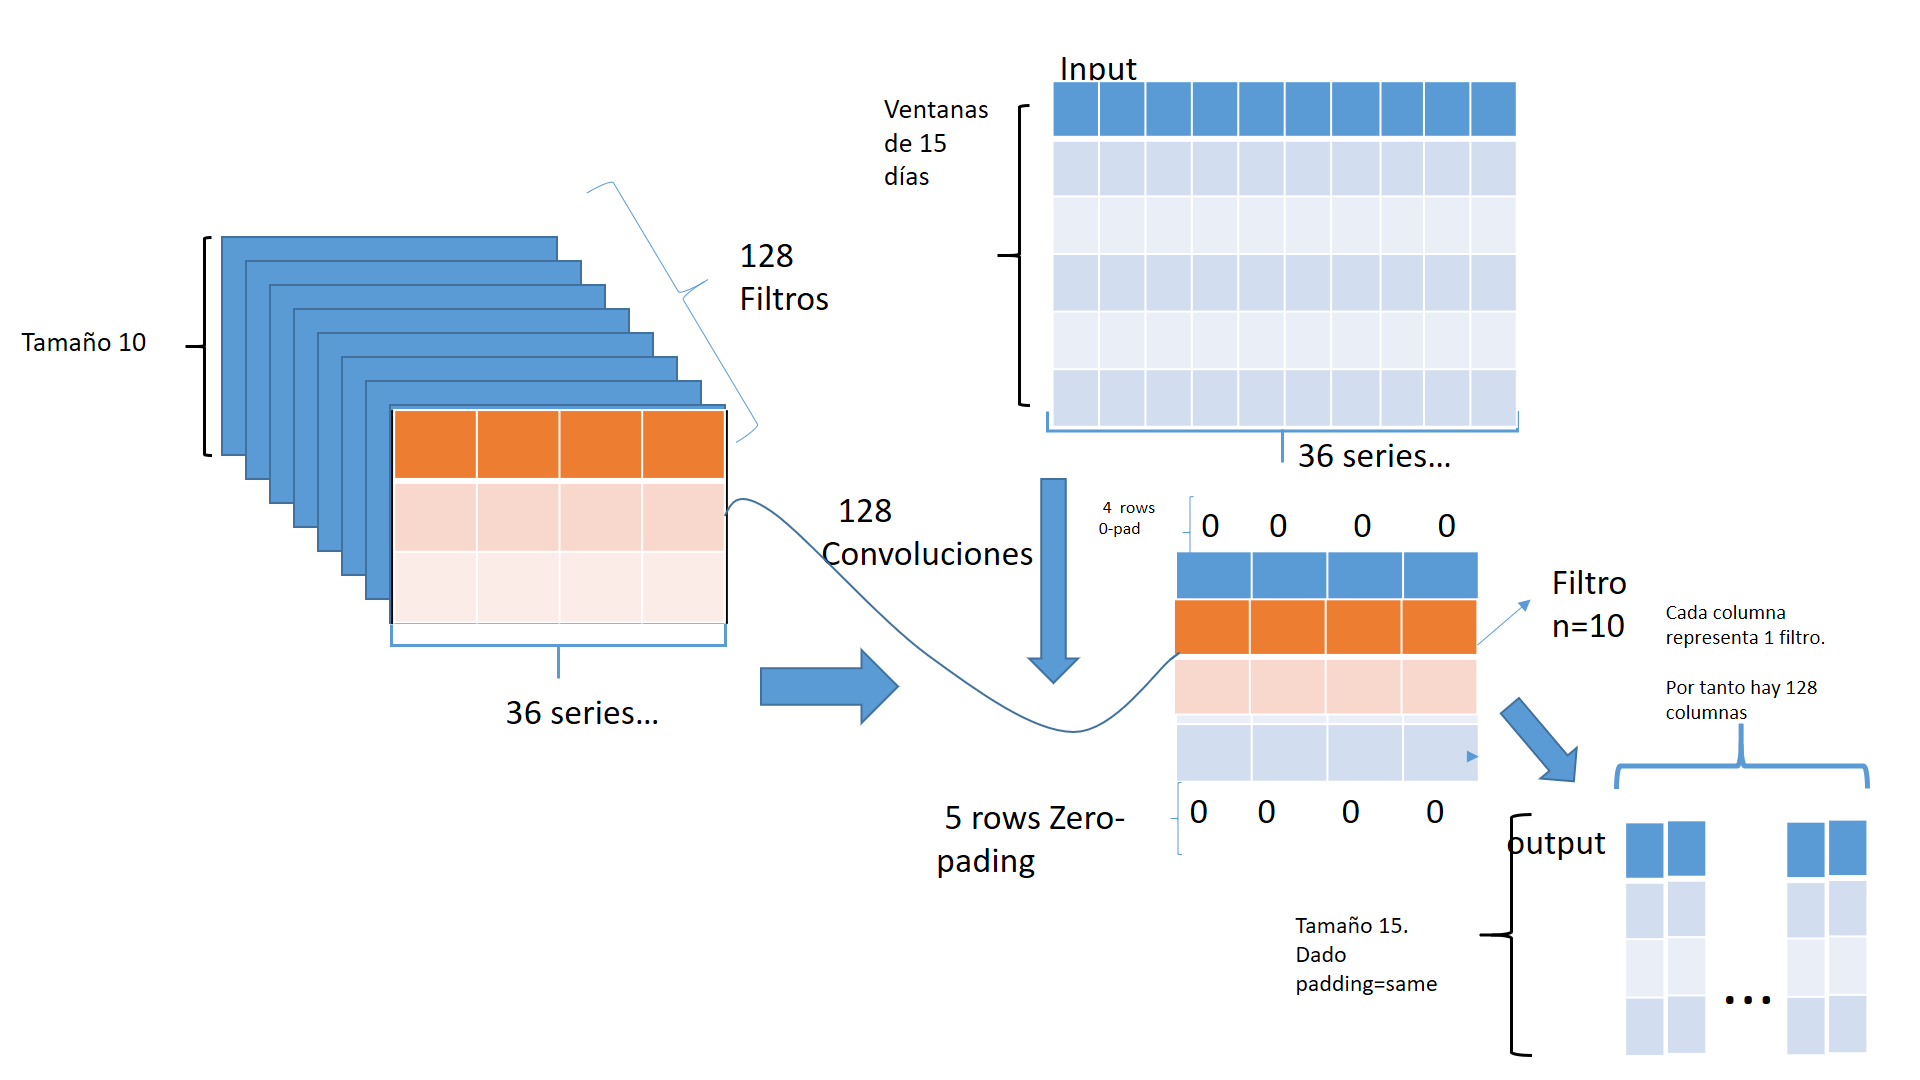

In [39]:
from IPython.display import Image
Image(filename='C:/Users/Abraham/Documents/cnnmine2.png')

#![]("C:\Users\Abraham\Documents\CNNmio.jpg"")

Por tanto esperamos una matriz de salida de 15x128 donde cada columna es el resultado de la convolución de cada fitro con la matriz input de 15x36 eso se corrobora viendo las dimensiones de salida de pred2.

de este modo primero obtenemos los 128 filtros contenidos en los pesos del layer "conv1d":

In [40]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[3].get_weights()

In [41]:
filters.shape,biases.shape

((10, 36, 128), (128,))

Los filtros tienes las dimensiones como se muestran en el dibujo, después estas los biases que hay que agregar después de hacer las convoluciones respectivas...

**Visualización de los primeros 3 filtros**

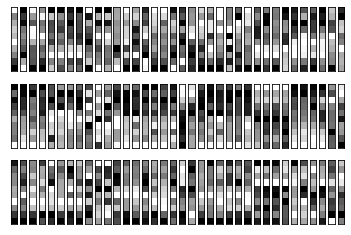

In [42]:
# plot first few filters
n_filters, ix = 3, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, i]
	# plot each channel separately
	for j in range(36):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 36, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:,j].reshape(-1,1), cmap='gray')
		ix += 1
# show the figure
plt.show()

Recordar que al hacer padding="same" se rellenan con zeros los vectores de cada una de las 36 columnas en este caso para conservar las dimensiones del input se tienene que meter 9 renglones con 0's 4 al principio y 5 al final cpmo se muestra en el dagrama de arriba:

In [43]:
yipad=np.vstack((np.vstack((np.zeros((4,36)),yi)),np.zeros((5,36))))
yipad.shape

(24, 36)

In [44]:
(np.sum(filters[:,:,0]*yipad[2:12,:])+biases[0])

0.6672305646483374

In [45]:
np.sum(f[:,0]*yi[:10,0])+biases[0]

-0.023849243318653353

Tenemos que crear la función LeakyRelu para aplicar después de la convolución...

In [46]:
def likirelu(x,alfa):
    if x<0:
        sal=alfa*x
        return(sal)
    else:
        return(x)

**Conv1D con función de activación LeakyRelu**

In [47]:
predman=np.zeros((15,128))
for j in range(128):
    for i in range(15):
        predman[i,j]=likirelu(np.sum(filters[:,:,j]*yipad[i:i+10,:])+biases[j],.1)

y Comparamos salidas....

In [48]:
pred2[0,:,127]

array([0.45862156, 0.5274807 , 0.58839566, 0.64644104, 0.7093635 ,
       0.715235  , 0.6964625 , 0.6833139 , 0.6809319 , 0.6767421 ,
       0.61537004, 0.56504047, 0.49450678, 0.436076  , 0.35973048],
      dtype=float32)

In [49]:
predman[:,127]

array([0.46255536, 0.53163924, 0.58902827, 0.64343927, 0.71383667,
       0.71972062, 0.69665232, 0.67874457, 0.68363244, 0.67597374,
       0.61626902, 0.56701323, 0.48836241, 0.43514469, 0.35733478])

## Layer 4 BatchNormalization

Bajo la misma explicación de 6.1 tenemos los siguiente:

In [50]:
print(model.layers[4].name)
model.layers[4].get_weights()

batch_normalization_1


[array([0.9539273 , 0.8306605 , 0.99516416, 0.975839  , 0.849056  ,
        0.9346981 , 0.8730302 , 0.90473396, 1.0434815 , 0.95838726,
        0.88518786, 0.90235376, 0.8291615 , 0.8715492 , 0.9359577 ,
        0.8931155 , 0.9538491 , 0.92747265, 1.0138613 , 0.86048955,
        0.9261638 , 0.91975594, 0.8564666 , 1.025928  , 0.91263   ,
        0.9804795 , 0.97560954, 0.8503863 , 0.9168027 , 0.9012972 ,
        0.96401626, 0.960646  , 0.89159125, 0.914943  , 1.021866  ,
        0.9191606 , 0.88527846, 0.9228716 , 0.9175348 , 0.9268428 ,
        0.9630522 , 0.9490821 , 0.8869737 , 0.984334  , 0.8988801 ,
        0.8749836 , 0.910123  , 0.9482397 , 1.0187516 , 1.0237877 ,
        0.9672201 , 1.0702142 , 0.84331805, 0.92311084, 1.0359477 ,
        1.097183  , 0.9127817 , 0.9102392 , 1.0146608 , 0.92052174,
        0.85694826, 0.9954321 , 0.8089716 , 0.8922912 , 0.9839197 ,
        1.0861045 , 0.9767858 , 0.9011924 , 0.9227547 , 0.94262177,
        0.862607  , 0.9094198 , 0.8227335 , 0.90

In [51]:
lay2out=[layer.output for layer in model.layers[:5]]
act3mod=Model(model.input,lay2out)
pred3=np.array(act3mod.predict(xx_test[0:1])[-1])
pred3

array([[[ 2.5005393 , -1.0879226 , -0.49721825, ..., -1.150049  ,
         -0.5609168 ,  1.7897025 ],
        [ 3.043509  , -1.1401182 , -0.5876113 , ..., -1.221228  ,
         -0.6126513 ,  2.1512794 ],
        [ 3.4689326 , -1.1979319 , -0.59883326, ..., -1.2812939 ,
         -0.607103  ,  2.4711413 ],
        ...,
        [ 2.6350822 , -1.2162588 , -0.44793954, ..., -1.2759473 ,
         -0.5237308 ,  1.9781345 ],
        [ 2.2097507 , -1.1802992 , -0.44861493, ..., -1.2393864 ,
         -0.45022392,  1.6713165 ],
        [ 1.7871746 , -1.1455787 , -0.47786593, ..., -1.1958764 ,
         -0.47514862,  1.2704291 ]]], dtype=float32)

Obteniendo la normalización de forma explícita...

In [52]:
bn=model.layers[4].get_weights()[0]*((predman-model.layers[4].get_weights()[2])/np.sqrt(model.layers[4].get_weights()[3]))+model.layers[4].get_weights()[1]
bn

array([[ 2.56677848, -1.11022901, -0.504179  , ..., -1.15878029,
        -0.53559162,  1.84403642],
       [ 3.14923047, -1.15791316, -0.60511423, ..., -1.24456722,
        -0.66558342,  2.21354157],
       [ 3.55938401, -1.21755471, -0.5972854 , ..., -1.31156671,
        -0.63953211,  2.52049514],
       ...,
       [ 2.68734838, -1.23832095, -0.45288005, ..., -1.29364992,
        -0.53965179,  1.98206914],
       [ 2.22719035, -1.19705182, -0.44641507, ..., -1.26857816,
        -0.47194124,  1.69742644],
       [ 1.80510227, -1.16544086, -0.47986016, ..., -1.2194231 ,
        -0.45680307,  1.28124884]])

In [53]:
bn=np.expand_dims(bn,axis=0)
bn.shape

(1, 15, 128)

## Layer 5 Maxpooling

In [54]:
print(model.layers[5].name)
model.layers[5].get_weights()

max_pooling1d


[]

In [55]:
pred3[0,:,1]

array([-1.0879226, -1.1401182, -1.1979319, -1.2437997, -1.2935957,
       -1.2981329, -1.3021548, -1.3023789, -1.3102709, -1.3065666,
       -1.2886751, -1.249107 , -1.2162588, -1.1802992, -1.1455787],
      dtype=float32)

In [56]:
lay3out=[layer.output for layer in model.layers[:6]]
act4mod=Model(model.input,lay3out)
pred4=np.array(act4mod.predict(xx_test[0:1])[-1])
pred4

array([[[ 4.2786474 , -1.0879226 , -0.49721825, -0.76068366,
         -1.2640159 ,  2.2793815 ,  1.2402296 ,  3.9927106 ,
          3.8059394 ,  5.16138   ,  3.1047533 ,  4.2269273 ,
          1.8212273 ,  0.88060975, -0.41790372,  1.6574008 ,
         -1.2925862 ,  3.843429  , -0.1391553 ,  2.6003602 ,
          3.3820279 ,  2.1067228 , -0.73585725, -0.75771147,
         -0.88497144, -0.94236773,  3.1257253 , -1.1259761 ,
          2.5269995 ,  3.995391  ,  4.755743  ,  4.051179  ,
          2.5735824 ,  3.0272737 , -0.9055861 ,  2.6225984 ,
         -0.82898366, -0.88724005,  2.5773873 , -1.2170417 ,
          3.2632122 ,  3.823877  ,  2.2788677 , -0.694811  ,
          3.6442044 ,  5.6934447 ,  2.5262785 ,  1.8852115 ,
         -0.860379  ,  4.9852724 , -1.1963625 , -0.7924377 ,
         -1.0645877 ,  3.3306463 , -0.86034507,  1.6508796 ,
          3.4488928 ,  1.9243348 ,  1.1420543 ,  3.1165593 ,
          4.4078727 ,  0.6881263 ,  1.5135432 ,  0.4258052 ,
         -0.7780832 , -0

### ¿Entendiste como funciona Maxpooling 1D?

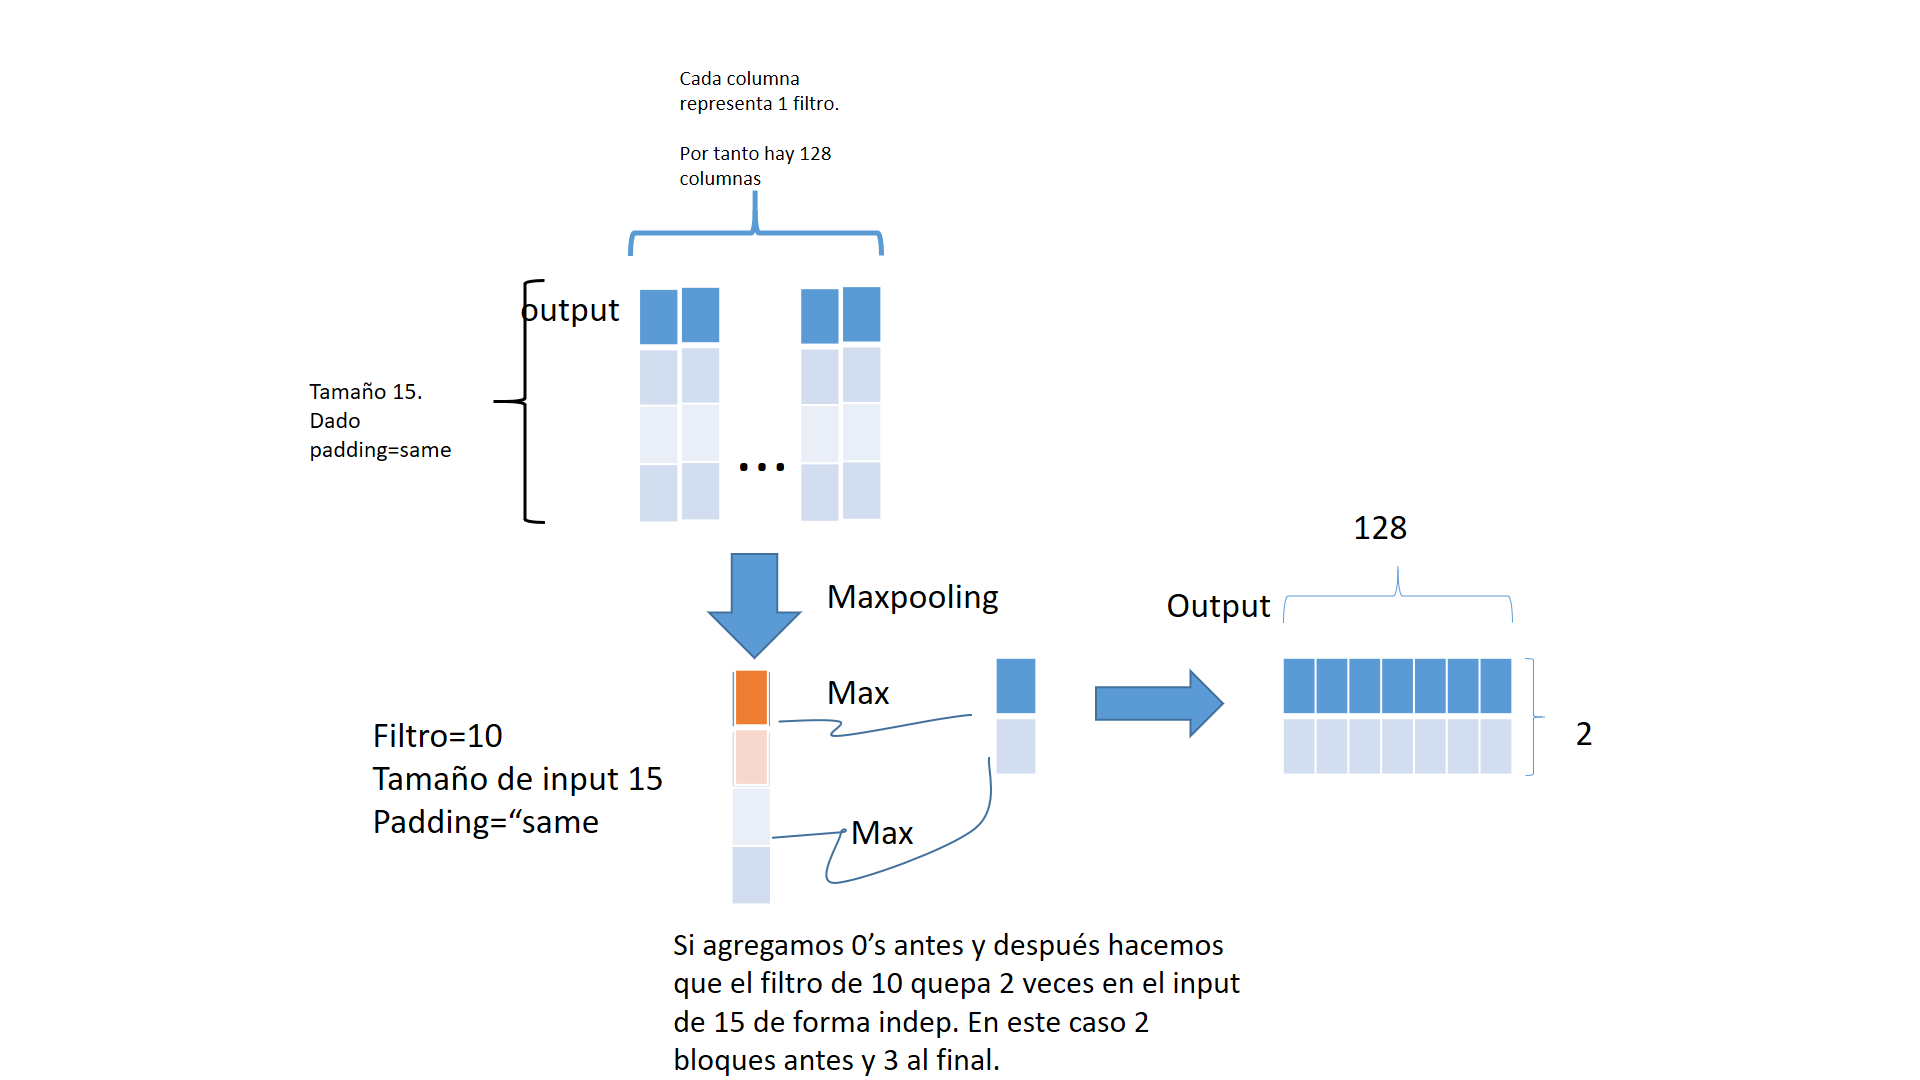

In [57]:
Image(filename='C:/Users/Abraham/Documents/maxpool.png')

In [58]:
np.max(bn[0,:8],axis=0).shape

(128,)

In [61]:
maxbn=np.zeros((2,128))
maxbn[0,:]=np.max(bn[0,:8],axis=0)
maxbn[1,:]=np.max(bn[0,8:],axis=0)
maxbn=np.expand_dims(maxbn,axis=0)
maxbn.shape

(1, 2, 128)

## Layer 6 Flatten

In [62]:
print(model.layers[6].name)
model.layers[6].get_weights()

flatten


[]

In [63]:
lay4out=[layer.output for layer in model.layers[:7]]
act5mod=Model(model.input,lay4out)
pred5=np.array(act5mod.predict(xx_test[0:1])[-1])
pred5.shape

(1, 256)

Flatten hace pasar de (2,128) a 2*128=256...

In [64]:
fmaxbn=maxbn.flatten()
fmaxbn.shape

(256,)

## Layer 7 BatchNormalization

In [65]:
print(model.layers[7].name)
model.layers[7].get_weights()

batch_normalization_2


[array([0.9839168 , 0.8766875 , 0.9942329 , 0.9958527 , 0.9066089 ,
        0.9472236 , 0.91700584, 0.955372  , 0.9924963 , 0.9821846 ,
        0.9267609 , 0.9359668 , 0.88012725, 0.9113857 , 0.9734801 ,
        0.9073425 , 0.9620673 , 0.95664173, 1.0131469 , 0.9325219 ,
        0.9551682 , 0.9518337 , 0.94637156, 1.0112728 , 0.953993  ,
        1.0009882 , 0.98080724, 0.9175346 , 0.91799957, 0.9464139 ,
        0.95675147, 0.95615995, 0.9560874 , 0.9297145 , 1.0333636 ,
        0.96279997, 0.9219402 , 0.96375877, 0.9829678 , 0.9551039 ,
        0.9944584 , 0.9745254 , 0.959942  , 0.9252345 , 0.96416026,
        0.9293784 , 0.9172977 , 0.95672286, 1.0156612 , 1.037715  ,
        0.98166645, 1.0510293 , 0.93040055, 0.94731015, 1.0333989 ,
        1.071764  , 0.938554  , 0.94270056, 1.0014352 , 0.9394132 ,
        0.94195604, 1.0010267 , 0.8641075 , 0.9624052 , 1.0038697 ,
        1.0322973 , 0.99758416, 0.9324424 , 0.9666041 , 0.97905725,
        0.8990162 , 0.9472543 , 0.9100747 , 0.96

In [68]:
lay5out=[layer.output for layer in model.layers[:8]]
act6mod=Model(model.input,lay5out)
pred6=np.array(act6mod.predict(xx_test[0:1])[-1])
pred6.shape

(1, 256)

In [67]:
bn2=model.layers[7].get_weights()[0]*((fmaxbn-model.layers[7].get_weights()[2])/np.sqrt(model.layers[7].get_weights()[3]))+model.layers[7].get_weights()[1]
bn2

array([ 3.77808679, -1.29214887, -0.73884727, -0.88424333, -1.50259392,
        1.97736428,  0.99166553,  3.62442975,  2.45090443,  4.47380796,
        2.66082778,  3.75581463,  1.59223703,  0.70080448, -0.60389519,
        1.3605371 , -1.51071415,  3.43367001, -0.91679492,  2.51121399,
        2.98289896,  1.75521182, -0.90673573, -1.22233138, -0.99790242,
       -1.31713647,  2.72606122, -1.32813505,  2.04619131,  3.87074832,
        3.99663832,  3.50203666,  2.20581916,  2.64188506, -1.38214697,
        2.29772767, -0.90969972, -1.14445059,  2.12078749, -1.41707856,
        2.42724841,  3.40180688,  1.97365973, -0.94779029,  3.41701519,
        5.11874911,  2.20877162,  1.88629829, -1.29935674,  3.95744523,
       -1.4553663 , -1.45805295, -1.29798588,  2.95527507, -1.47494043,
        0.44347158,  3.06303542,  1.37564111,  0.69331451,  2.74862031,
        4.22261467,  0.65057853,  1.38243649,  0.34832427, -1.24896971,
       -0.85801329,  1.74398197, -0.85782141,  2.19079325, -1.33

In [69]:
bn2=np.expand_dims(bn2,axis=0)
bn2.shape

(1, 256)

## layer 8 Dense 200

Estamos usando 256 inputs a 200 nueronas  por tanto tenemos una matriz de 256 X 200  y un vector de 200 elemntos que es el bias.

In [73]:
print(model.layers[8].name)
model.layers[8].get_weights()[0].shape,model.layers[8].get_weights()[1].shape

dense


((256, 200), (200,))

In [94]:
lay6out=[layer.output for layer in model.layers[:9]]
act7mod=Model(model.input,lay6out)
pred7=np.array(act7mod.predict(xx_test[0:1])[-1])
pred7.shape

(1, 200)

### ¿Cómo obtenemos la salida de esta neurona L?

$$z^{(L)}=\sigma(a^{(L)}*W^{(L)}+b^{(L)})$$

donde $\sigma$ representa la funció de activación...

In [95]:
nbn2=np.tanh(np.dot(bn2,model.layers[8].get_weights()[0])+model.layers[8].get_weights()[1])
nbn2.shape

(1, 200)

## Layer 9 BatchNorm

In [96]:
print(model.layers[9].name)
model.layers[9].get_weights()

batch_normalization_3


[array([0.9949902 , 0.979499  , 0.99561644, 0.9719005 , 0.9704917 ,
        0.9790191 , 0.9823314 , 0.9791075 , 0.9814622 , 0.97832054,
        1.0152832 , 0.9846225 , 0.96917576, 0.99138063, 0.9755305 ,
        0.9808593 , 0.9164761 , 0.99466443, 0.97929376, 0.9889639 ,
        0.97941643, 0.97338635, 0.9803799 , 0.9880321 , 0.9897238 ,
        0.97992283, 0.9639073 , 0.90557635, 0.99359506, 0.976074  ,
        0.98462147, 0.9810905 , 0.95920557, 1.0067347 , 1.0048919 ,
        0.9743504 , 0.9836499 , 1.0020447 , 1.0012403 , 0.98380125,
        0.9957167 , 0.99291855, 0.97396964, 0.98483866, 0.9793886 ,
        1.0001366 , 0.9899594 , 0.97771585, 0.9786836 , 0.9996909 ,
        0.9820473 , 0.97584015, 1.002928  , 0.97854894, 0.97649056,
        0.9734145 , 0.9791332 , 0.96450037, 0.9957878 , 0.9763047 ,
        0.9576758 , 0.98470616, 0.99726266, 1.0115844 , 0.9648193 ,
        0.93278384, 0.98168033, 0.9778333 , 0.9813792 , 0.99189746,
        0.9721068 , 0.9879051 , 0.9866193 , 0.99

In [97]:
lay7out=[layer.output for layer in model.layers[:10]]
act8mod=Model(model.input,lay7out)
pred8=np.array(act8mod.predict(xx_test[0:1])[-1])
pred8

array([[ 1.7121586 ,  2.1808593 , -1.5898863 ,  1.149472  , -0.01404821,
        -1.1460103 ,  2.558592  , -1.8621525 ,  3.4630148 ,  1.512109  ,
         1.7580124 ,  1.7675335 , -1.4577285 ,  1.5683424 , -0.90389794,
        -2.0093596 ,  0.44033796, -1.3416532 ,  0.5294302 , -1.3317928 ,
        -1.2161064 , -2.3186102 ,  4.001842  , -1.3791211 ,  1.4996125 ,
        -1.2336016 , -0.12445725,  0.77719736,  1.4608645 ,  0.48231393,
         1.2347662 ,  3.170248  ,  1.5601546 ,  2.8972242 ,  0.69252044,
        -2.179869  ,  1.156474  ,  1.5076855 , -1.9883354 , -1.6016506 ,
         1.0981362 ,  1.1972134 , -1.4924878 ,  1.6343545 , -1.1542801 ,
         1.3804772 ,  2.0423138 , -1.6015782 ,  2.090783  , -1.5822166 ,
         1.5380269 ,  1.0925566 ,  2.0394557 , -2.3519351 ,  5.082342  ,
        -1.5445081 , -2.3396502 , -0.07337902, -1.4510456 ,  1.2387583 ,
         1.2361856 , -2.5861707 ,  1.6824274 ,  2.3357716 ,  2.419481  ,
         0.5735342 ,  2.2433836 , -0.28523672, -1.2

In [98]:
bn3=model.layers[9].get_weights()[0]*((nbn2-model.layers[9].get_weights()[2])/np.sqrt(model.layers[9].get_weights()[3]))+model.layers[9].get_weights()[1]
bn3

array([[ 1.76152146,  2.31191498, -1.66089528,  1.18077838, -0.02245869,
        -1.18054109,  2.64910413, -1.90059148,  4.63102118,  1.57240451,
         1.77926209,  1.97594638, -1.50998582,  1.60148233, -1.01196766,
        -2.32311559,  0.47235305, -1.39277224,  0.57788289, -1.36888256,
        -1.36785454, -2.55399418,  4.06028095, -1.43857434,  1.55281946,
        -1.28972542, -0.15942018,  0.82839143,  1.48517076,  0.60139561,
         1.28224167,  3.75381158,  1.67409344,  2.91435125,  0.72165645,
        -2.29590267,  1.19133469,  1.53853286, -2.03404858, -1.67293586,
         1.10676593,  1.21883527, -1.55276497,  1.67139411, -1.2012042 ,
         1.41097697,  2.11227246, -1.76015278,  2.23504494, -1.64924023,
         1.56754068,  1.26984339,  2.07626108, -2.45624421,  6.00746687,
        -1.61291087, -2.44061271, -0.09829314, -1.47833368,  1.57426686,
         1.37778175, -2.68952055,  1.70912253,  2.36612505,  2.67121677,
         0.62805498,  2.36062193, -0.32565371, -1.2

## Layer 10 Dense 2

Entrada 200 inputs salida 2 entonces matriz de 200 x 2  y vector de 2 que es el bias

In [99]:
print(model.layers[10].name)
model.layers[10].get_weights()[0].shape,model.layers[10].get_weights()[1].shape

dense_1


((200, 2), (2,))

In [100]:
lay8out=[layer.output for layer in model.layers[:11]]
act9mod=Model(model.input,lay8out)
pred9=np.array(act9mod.predict(xx_test[0:1])[-1])
pred9

array([[0.9786708 , 0.02132924]], dtype=float32)

Recordar que esta neurona usa funcioón de activación softmax:

$$\sigma(\mathbf{z})_{j}=\frac{e^{z_{j}}}{\sum_{k=1}^{K} e^{z_{k}}} \quad \text { para } j=1, \ldots, K$$

In [102]:
z=np.dot(bn3,model.layers[10].get_weights()[0])+model.layers[10].get_weights()[1]
z

array([[ 1.46898702, -2.3033805 ]])

In [110]:
sz=np.exp(z)/np.sum(np.exp(z))
sz

array([[0.97751945, 0.02248055]])

Podemos ver con esto que coinciden los scores por clase, y si vemos el modelo total tenemos:


In [111]:
model.predict(xx_test[0:1])

array([[0.9786708 , 0.02132924]], dtype=float32)

**Hemos replicado ele entendimineto de los cálculos del la red usando los pesos**